In [1]:
import anndata as ad
import pandas as pd
import shapely
import shapely.plotting as splot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load and subset data

In [2]:
adata = ad.read_h5ad("../data/merfish_638850_AIT17.custom_CCF_annotated_TH_ZI_only_2023-05-04_00-00-00/atlas_brain_638850_AIT17_custom_CCF_annotated_TH_ZI_only.h5ad")
adata

AnnData object with n_obs × n_vars = 191578 × 550
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'cluster_id', 'cluster_label', 'supertype_id_label', 'Level2_id_label', 'Level1_id_label', 'class_id_label', 'cluster_id.AIT16', 'nt_type_label', 'luster_id', 'subclass_id_label', 'He.label', 'He.cor', 'class_label', 'division_label', 'division_id_label', 'subclass_label', 'supertype_label', 'nt_type_combo_label', 'CCF_landmark', 'CCF_bin_x', 'CCF_bin_y', 'CCF_bin_z', 'structures_id', 'CCF_acronym', 'CCF_analysis', 'CCF_broad', 'napari_x', 'napari_y', 'is_in_TH_or_ZI'
    u

In [3]:
adata.obs['cirro_x'] = adata.obsm['spatial_cirro'][:,0]
adata.obs['cirro_y'] = adata.obsm['spatial_cirro'][:,1]

In [21]:
from collections import defaultdict
from shapely.ops import unary_union

ccf_polygons = defaultdict(dict)
poly_from_obs = lambda df: shapely.concave_hull(shapely.multipoints(df[['cirro_x','cirro_y']].values), allow_holes=True, ratio=0.3)
for (name, section), df in adata.obs.groupby(['CCF_acronym', 'section']):
    if len(df)>10:
        midpoint = df['cirro_x'].mean()
        if np.min(np.abs(df['cirro_x'] - midpoint)) > 100:
            left = df.loc[df['cirro_x'] < midpoint]
            right = df.loc[df['cirro_x'] > midpoint]
            ccf_polygons[name][section] = unary_union([poly_from_obs(left), poly_from_obs(right)])
        else:
            ccf_polygons[name][section] = poly_from_obs(df)

In [5]:

def plot_polygon(ccf_polygons, name):
    for poly in ccf_polygons[name].values():
        splot.plot_polygon(poly, add_points=False)

name = 'ZI'
plt.figure(figsize=(20,10))
plot_polygon(ccf_polygons, name)

In [28]:
nuclei_df = pd.read_csv("../resources/Prong 1 Vitessce links by nucleus.csv", index_col=0)



def plot_nucleus_cluster_comparison(name, adata, nuclei_df, ccf_polygons, subregions=None):
    plt.figure(figsize=(40,10))
    if subregions is not None:
        for x in subregions:
            for poly in ccf_polygons[x].values():
                splot.plot_polygon(poly, color='grey', add_points=False)
    else:
        for poly in ccf_polygons[name].values():
            splot.plot_polygon(poly, color='grey', add_points=False)
    clusters = nuclei_df.loc[name, "annotated clusters"].split(', ')
    df = adata.obs.loc[lambda df: df['cluster_label'].str[:4].isin(clusters)]
    df['cluster_label'].cat.remove_unused_categories(inplace=True)
    sns.scatterplot(df, x='cirro_x', y='cirro_y', hue='cluster_label', s=2)

In [6]:
%matplotlib widget

In [8]:
%matplotlib inline

<ipython-input-28-c2c25b0ddcf0>:16: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


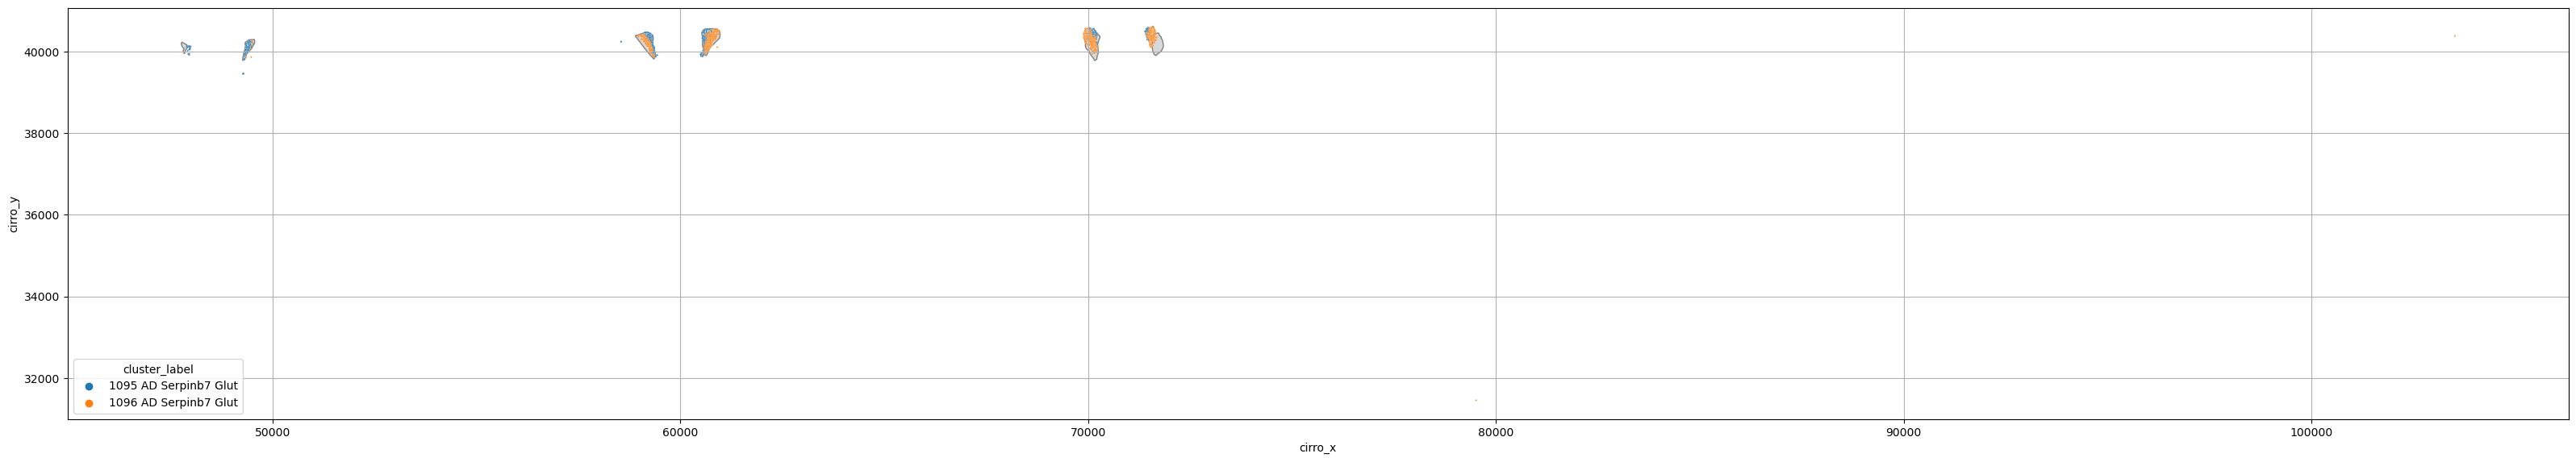

In [29]:
plot_nucleus_cluster_comparison('AD', adata, nuclei_df, ccf_polygons)

<ipython-input-28-c2c25b0ddcf0>:16: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


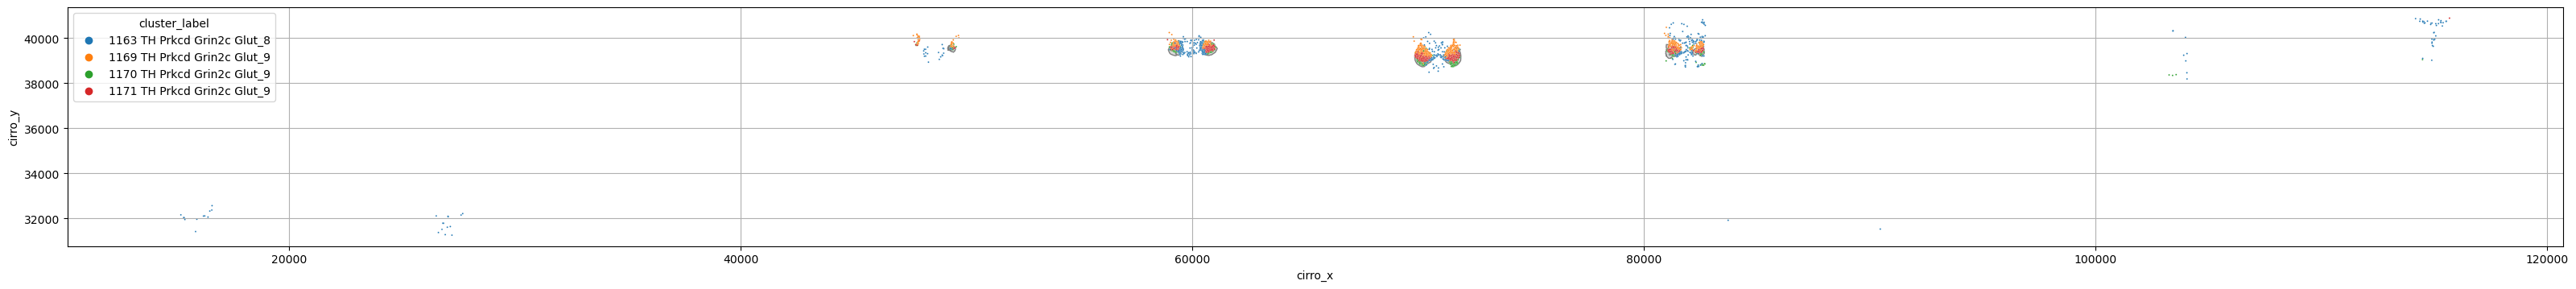

In [30]:
plot_nucleus_cluster_comparison('AM', adata, nuclei_df, ccf_polygons, subregions=['AMd','AMv'])

<ipython-input-15-ff7a9ff7786d>:11: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


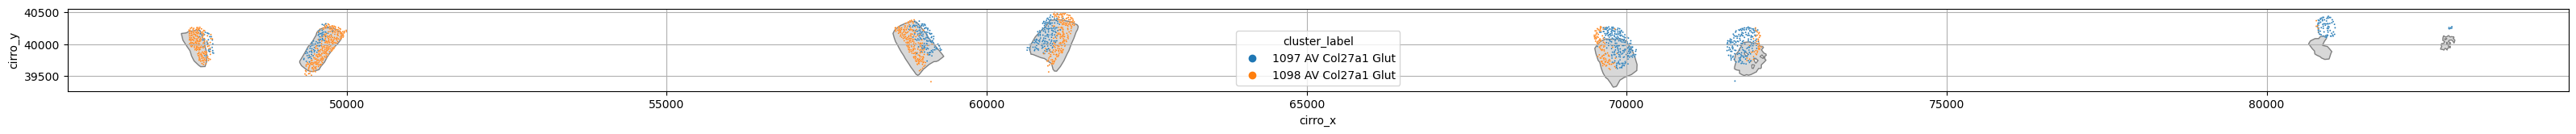

In [22]:
plot_nucleus_cluster_comparison('AV', adata, nuclei_df, ccf_polygons)

<ipython-input-28-c2c25b0ddcf0>:16: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


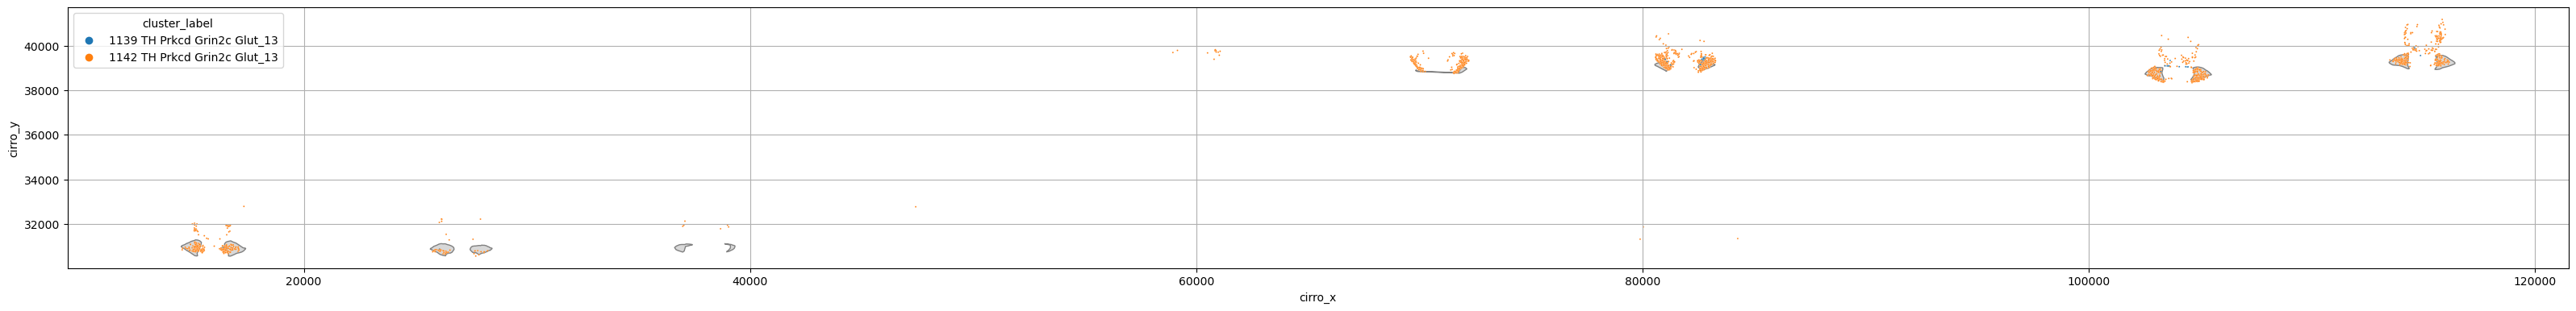

In [31]:
plot_nucleus_cluster_comparison('VM', adata, nuclei_df, ccf_polygons)

<ipython-input-28-c2c25b0ddcf0>:16: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


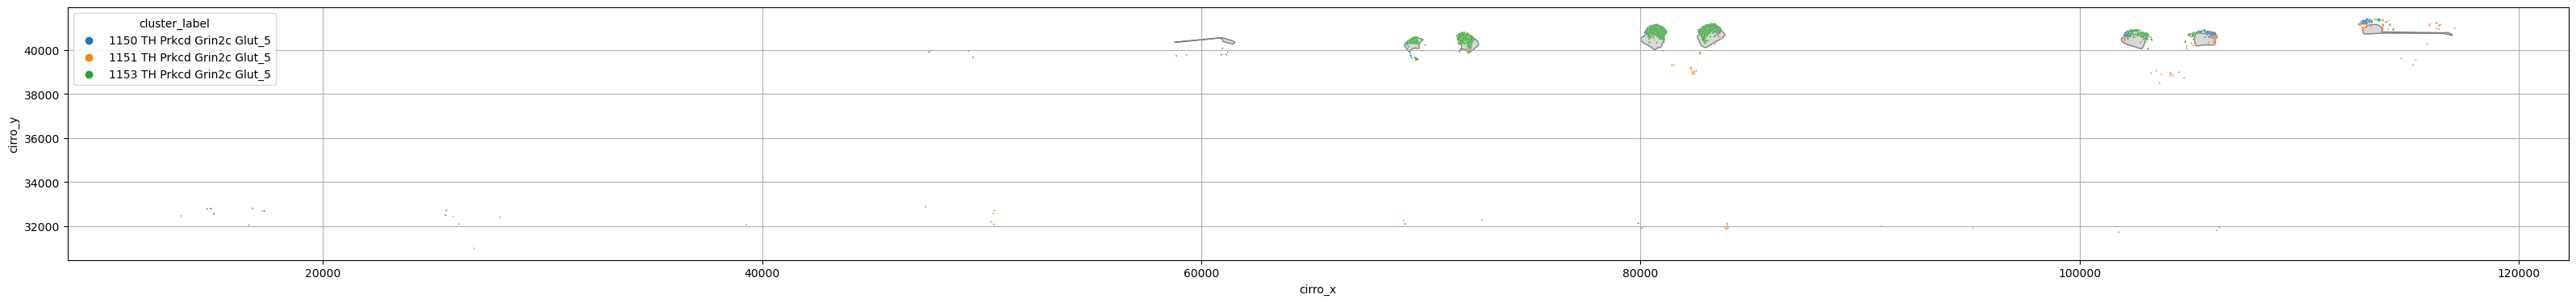

In [33]:
plot_nucleus_cluster_comparison('LD', adata, nuclei_df, ccf_polygons)